In [1]:
#%run data.py

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import stat
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm

In [62]:
day_0 = pd.read_csv("prices_round_3_day_0.csv", sep=";")
day_1 = pd.read_csv("prices_round_3_day_1.csv", sep=";")
day_2 = pd.read_csv("prices_round_3_day_2.csv", sep=";")

all_days = pd.concat([day_0,day_1,day_2], ignore_index=True)
print(all_days.head())

   day  timestamp       product  bid_price_1  bid_volume_1  bid_price_2  \
0    0          0     CHOCOLATE         7999           111          NaN   
1    0          0  STRAWBERRIES         3999           210          NaN   
2    0          0         ROSES        14999            72          NaN   
3    0          0   GIFT_BASKET        71348            19      71347.0   
4    0        100   GIFT_BASKET        71344             1      71343.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0           NaN          NaN           NaN         8001           111   
1           NaN          NaN           NaN         4001           210   
2           NaN          NaN           NaN        15001            72   
3          24.0          NaN           NaN        71362            19   
4          12.0      71342.0          20.0        71355             1   

   ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0          NaN           NaN          Na

In [63]:
roses = all_days[all_days['product'] == "ROSES"].reset_index()
gifts = all_days[all_days['product'] == "GIFT_BASKET"].reset_index()

In [64]:
mid_price = pd.DataFrame({
    "Roses": roses['mid_price'],
    "Gifts": gifts['mid_price']
}, index = roses.index)
print(mid_price.head())

     Roses    Gifts
0  15000.0  71355.0
1  15000.0  71349.5
2  15000.5  71347.0
3  15000.0  71350.5
4  14997.5  71341.5


In [76]:
# taking the rolling window
"""
def calculate_hedge_ratio(col1, col2):
    # Check if window contains enough data
    if col1.shape[0] != col2.shape[0] < 2:
        return None
    
    Y = col1
    X = col2 # Adding a constant term
    model = sm.OLS(Y, X).fit()
    beta = model.params.iloc[0]
    std_err = model.bse.iloc[0]
    lower_bound = beta - std_err
    upper_bound = beta + std_err
    return (lower_bound, beta, upper_bound)  # Return the beta coefficient
"""

"""
def calculate_hedge_ratio(col1, col2):
    # Ensure both columns have the same amount of data and there are at least two data points
    if len(col1) != len(col2) or len(col1) < 2:
        return None

    # Convert to numpy arrays
    Y = np.array(col1)
    X = np.array(col2)
    
    # Adding a constant term to X to include an intercept in the model
    X = np.vstack([X, np.ones(len(X))]).T

    # Calculate the beta coefficients using the normal equation
    # Beta = (X'X)^(-1)X'Y
    XTX = np.dot(X.T, X)
    XTY = np.dot(X.T, Y)
    beta = np.linalg.solve(XTX, XTY)  # This returns [beta_slope, beta_intercept]

    # Estimating errors (standard errors)
    predictions = np.dot(X, beta)
    residuals = Y - predictions
    residual_variance = np.dot(residuals.T, residuals) / (len(Y) - X.shape[1])  # Degree of freedom adjusted
    cov_matrix = np.linalg.inv(XTX) * residual_variance
    std_errs = np.sqrt(np.diag(cov_matrix))

    beta_slope = beta[0]
    std_err = std_errs[0]

    lower_bound = beta_slope - std_err
    upper_bound = beta_slope + std_err
    
    return (lower_bound, beta_slope, upper_bound)  # Return the beta coefficient and confidence bounds
"""
def calculate_hedge_ratio(prices_X, prices_Y):
    # Add an intercept term with a column of ones
    A = np.vstack([prices_X, np.ones(len(prices_X))]).T
    
    # Perform linear regression
    beta, intercept = np.linalg.lstsq(A, prices_Y, rcond=None)[0]

    return beta,intercept

In [96]:
# Apply rolling regression to calculate hedge ratio
hedge_ratio_30 = calculate_hedge_ratio(mid_price[:90]['Roses'], mid_price[:90]['Gifts'])
print(hedge_ratio_30)

(0.7770402732081497, 59702.178653449504)


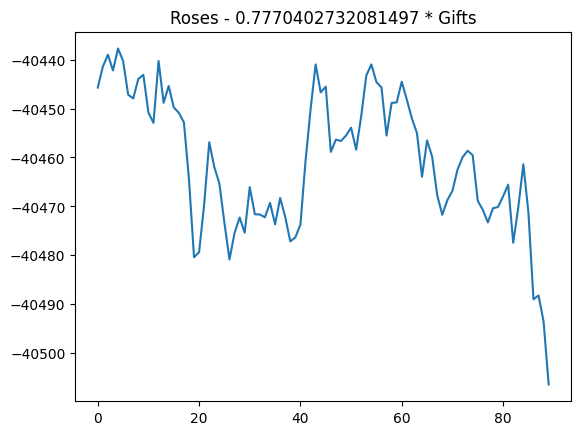

In [97]:
spread = mid_price['Roses'][:90] - hedge_ratio_30[0] * mid_price['Gifts'][:90]
plt.plot(spread)
plt.title(f"Roses - {hedge_ratio_30[0]} * Gifts")
plt.show()

In [80]:
spread_upper_bound =mid_price['Roses'][:90] - hedge_ratio_30[0] * mid_price['Gifts'][:90]
spread_lower_bound = mid_price['Roses'][:90] - hedge_ratio_30[2] * mid_price['Gifts'][:90]

plt.plot(spread, label="Spread")
plt.plot(spread_upper_bound, label="Spread Upper Bound")
plt.plot(spread_lower_bound, label="Spread Lower Bound")
plt.title(f"Roses - {hedge_ratio_30[1]} * Gifts")
plt.legend()
plt.show()

IndexError: tuple index out of range

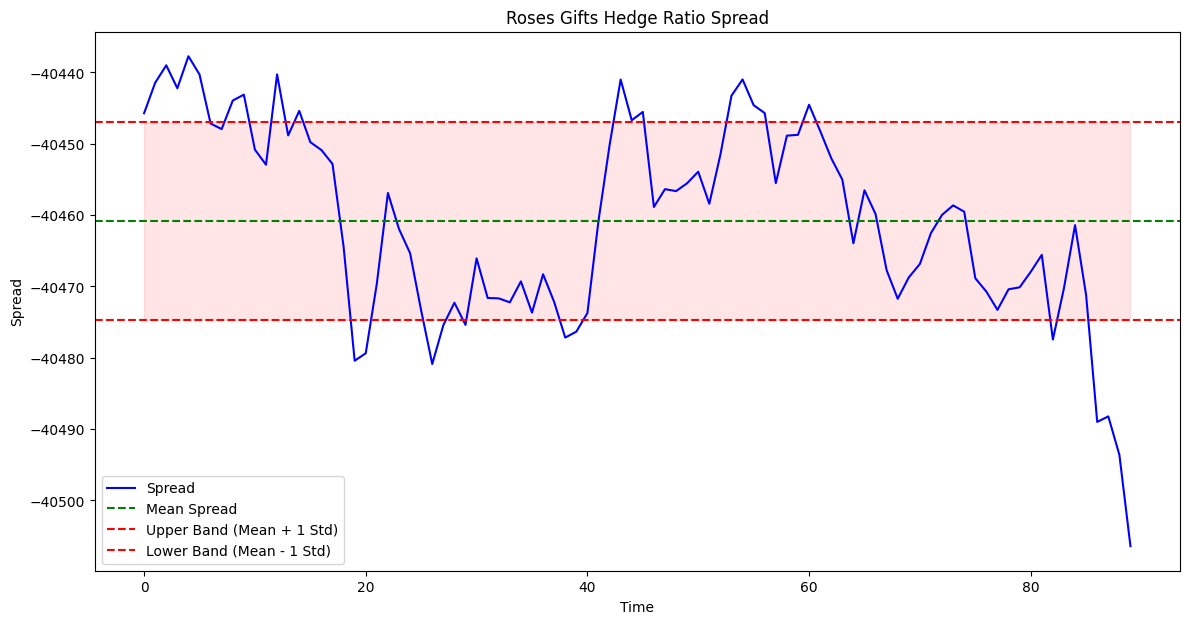

In [81]:
spread_mean = np.mean(spread)
spread_std = np.std(spread)

upper_band = spread_mean + spread_std
lower_band = spread_mean - spread_std

plt.figure(figsize=(14, 7))
plt.plot(spread, label='Spread', color='blue')
plt.axhline(spread_mean, color='green', linestyle='--', label='Mean Spread')
plt.axhline(upper_band, color='red', linestyle='--', label='Upper Band (Mean + 1 Std)')
plt.axhline(lower_band, color='red', linestyle='--', label='Lower Band (Mean - 1 Std)')

plt.fill_between(spread.index, lower_band, upper_band, color='red', alpha=0.1)

plt.title('Roses Gifts Hedge Ratio Spread')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [82]:
print(mid_price.rolling(30))

Rolling [window=30,center=False,axis=0,method=single]


In [83]:
# now generalize over a 30 day rolling window
window_size = 30  # Define window size

# Correct approach to apply complex operations on rolling windows
mid_price['Beta'] = [
    calculate_hedge_ratio(mid_price.iloc[i:i+window_size]['Roses'], mid_price.iloc[i:i+window_size]['Gifts']) if i >= window_size else np.nan
    for i in range(len(mid_price.index))
]

# Fill the remaining values with NaN
mid_price['Beta'].fillna(0, inplace=True)
print(mid_price[30:60])

      Roses    Gifts                                       Beta
30  14964.5  71335.5    (0.9747102946993971, 56737.30095676465)
31  14960.5  71337.5    (0.3844682756760386, 65564.42974900077)
32  14958.5  71335.0   (0.07960878942566527, 70123.27259817171)
33  14956.0  71332.5  (0.018981880931143127, 71029.40530630892)
34  14953.5  71325.5    (0.1579032286978178, 68951.10719600055)
35  14956.5  71335.0    (0.34797026455883445, 66108.2079658789)
36  14954.5  71325.5   (0.40163934426254244, 65304.77950819303)
37  14954.5  71330.5     (0.49988844265924, 63834.935296746844)
38  14956.5  71339.5    (0.7627860026929709, 59902.53286225239)
39  14955.0  71336.5    (1.1422906870658636, 54225.77782651259)
40  14954.5  71332.5    (1.3839376482550827, 50610.87360216497)
41  14955.0  71316.5    (1.5684985586018843, 47849.85415250811)
42  14955.5  71303.5    (1.6696079903880219, 46337.44684964678)
43  14951.5  71286.5      (1.54472576900736, 48205.92554773932)
44  14952.0  71294.5    (1.2136780837259

In [84]:
mid_price['Beta'].fillna(0, inplace=True)
print(mid_price['Beta'])

0                                                 0
1                                                 0
2                                                 0
3                                                 0
4                                                 0
                            ...                    
29995       (4.109848484853151, 10315.617424175187)
29996      (3.8770053475914623, 13671.585561527909)
29997      (-7.499999999944623, 177635.74999920191)
29998      (-14.000000000001362, 271317.0000000196)
29999    (4.826423319231113, 0.0003349008305333319)
Name: Beta, Length: 30000, dtype: object


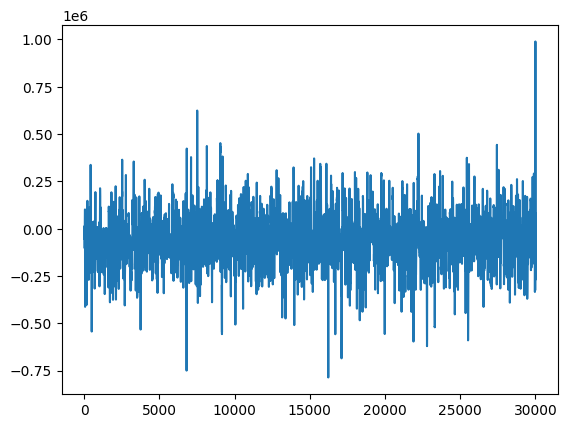

In [85]:
# Calculate Spread and store it in a new column
mid_price['Spread'] = mid_price['Roses'][30:] - mid_price['Beta'][30:].apply(lambda x: x[0]) * mid_price['Gifts'][30:]
plt.plot(mid_price['Spread'])

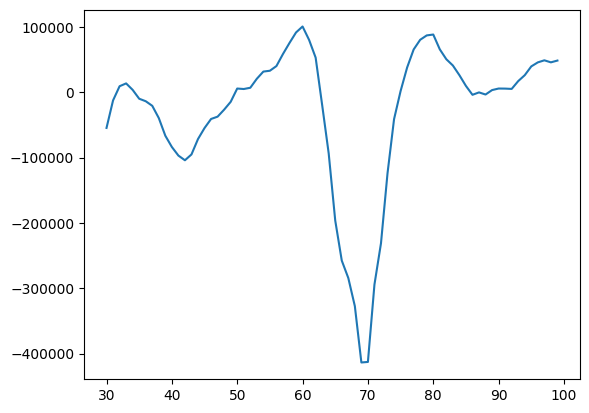

In [86]:
plt.plot(mid_price['Spread'][:100])

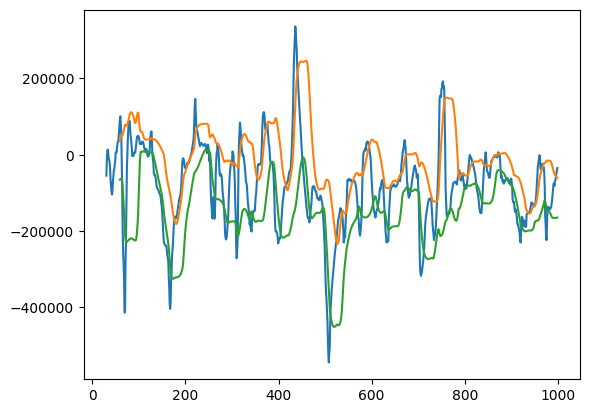

In [87]:
mid_price['Spread_Mean'] = mid_price['Spread'].rolling(30).mean()
mid_price['Spread_Std'] = mid_price['Spread'].rolling(30).std()
mid_price['Spread_Upper_Bound'] = mid_price['Spread_Mean'] + mid_price['Spread_Std']
mid_price['Spread_Lower_Bound'] = mid_price['Spread_Mean'] - mid_price['Spread_Std']

plt.plot(mid_price['Spread'][:1000])
plt.plot(mid_price['Spread_Upper_Bound'][:1000])
plt.plot(mid_price['Spread_Lower_Bound'][:1000])

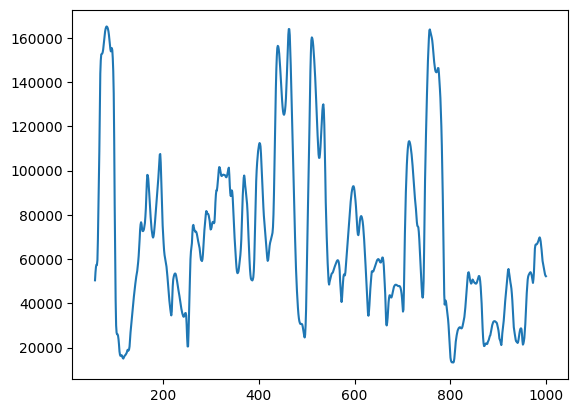

In [88]:
plt.plot(mid_price['Spread_Std'][:1000])

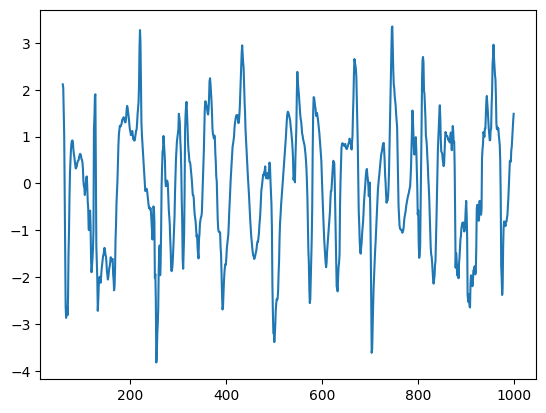

In [89]:
# plot the z_score
z_score = (mid_price["Spread"] - mid_price["Spread_Mean"])/mid_price["Spread_Std"] 
plt.plot(z_score[:1000])

In [90]:
buy = z_score < -2.0
sell = z_score > 2.0

(0.0, 5000.0)

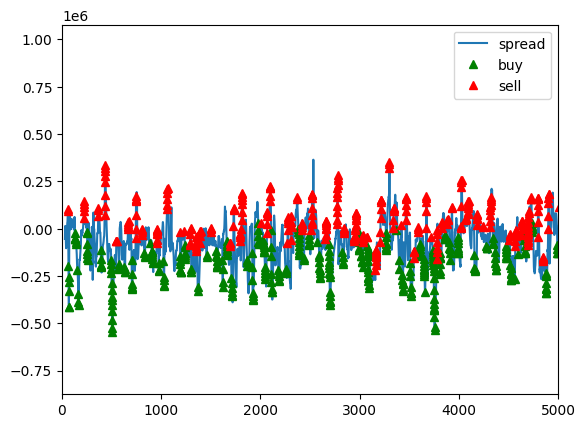

In [91]:
mid_price['Spread'].plot(label = 'spread')
mid_price[buy]['Spread'].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
mid_price[sell]['Spread'].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.legend()
plt.xlim([0, 5000])

(14500.0, 15000.0)

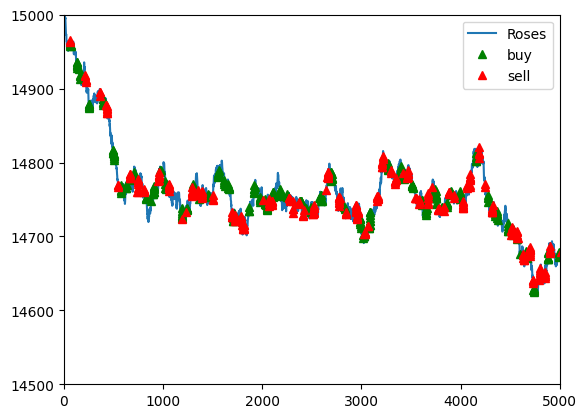

In [92]:
mid_price['Roses'].plot(label = 'Roses')
mid_price[buy]['Roses'].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
mid_price[sell]['Roses'].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.legend()
plt.xlim([0, 5000])
plt.ylim([14500,15000])